## Interpreting BERT based Seq2Seq (i.e NER) models

In my teens, I found that  cognitive psychology  and biotechnology  could hold the world in suspended animation. There is a great deal of mystery and joy in understanding the delicate and intricate internal processes that lead to external (visible) action. More than a decade later, pytorch based NLP models turned out be a fair enough substitute. So here is an analysis of Named Entity Recognition (NER) Model.<br> The model used here is an NER model fine tuned with BERT-base. It  was obtained from https://github.com/kamalkraj/BERT-NER

## Objectives:
<ol>
  <li> Take a target word and visualize how every other word contributes to the final tag for the target word </li>
  <li> For the target word selected above, zoom into  how much information the comes  word embeddings and position embedding from every word word in the sentence</li>
  <li> Zoom one step inside and understand how much each layer of a sample word contributes to the final tag of the target word</li>    
</ol>

We will be exploring how the word "Rob" in the sentence "Soccer - Steve Tiger  gets a lucky win , Rob in surprise defeat" gets tagged as "B-PER". We will also look at the effect 12 embedding layers  of the word "surprise" have on "Rob" being tagged as "B-PER"

In [7]:
text = "Soccer - Steve Tiger  gets a lucky win , Rob in surprise defeat"
target_word ='Rob'
token_to_explain_target_Word = 'surprise' # this is used in the last part to understand how each layer 
#of this word contributed to the tage for the desired word

In [2]:
from bert import Ner
import torch
import torch.nn.functional as F

In [3]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [4]:
nerModel = Ner("/data/home/gilopez/notebooks/Interpretability/BERT-NER/model/out_base")
# load tokenizer
tokenizer = nerModel.tokenizer

For the target word we have to obtain the actual label. As a hack, I am just using label predicted by the model. the code snippet below identifies the tag and word position of the target word. It also identifies the word index of a sample word, the effect of whose  layers will be analyzed

In [5]:
output = nerModel.predict(text)

tag=''
word_position = 0 # just initializing. This is word whose tag we are trying to explain
rowNum = 0 # we have only 1 sentence we use for prediction

for ind,row in enumerate(output):
    if row['word'] == target_word:
        tag = row['tag']
        word_position = ind +1 #for cls token
        print(row)
        break
print("tag",tag)
print("word_position",word_position)
tag_index = nerModel.label_word_ind[tag]
print("tag_index",tag_index)
token_to_explain = 0 # the index of the token that we would like to examine each layer of
for ind,row in enumerate(output):
    if row['word'] == token_to_explain_target_Word:
        tag = row['tag']
        token_to_explain = ind +1 #for cls token
        print(row)
        break
print("token_to_explain_index",token_to_explain)

{'word': 'Rob', 'tag': 'B-PER', 'confidence': 0.9996005892753601}
tag B-PER
word_position 10
tag_index 4
{'word': 'surprise', 'tag': 'O', 'confidence': 0.9999698400497437}
token_to_explain_index 12


Next, we have to get the tensor values of all the inputs. For this we convert word into indices, and we have a mask to eliminate padded words in our analysis

In [6]:

input_ids,input_mask,segment_ids,valid_ids,all_tokens = nerModel.preprocess_infer(text)
input_ids = torch.tensor([input_ids],dtype=torch.long,device=nerModel.device)
input_mask = torch.tensor([input_mask],dtype=torch.long,device=nerModel.device)
segment_ids = torch.tensor([segment_ids],dtype=torch.long,device=nerModel.device)
valid_ids = torch.tensor([valid_ids],dtype=torch.long,device=nerModel.device)
position_ids = torch.tensor([[x for x in range(len(all_tokens))]],dtype=torch.long,device=nerModel.device)

In [8]:
position_ids.shape,input_ids.shape,input_mask.shape,segment_ids.shape # [batch size , num_words]

(torch.Size([1, 15]),
 torch.Size([1, 15]),
 torch.Size([1, 15]),
 torch.Size([1, 15]))

While working with attribution based methods we need a reference sentence. In this case, we can substitute  every word in the original sentence with '[PAD]' and use it as reference. The model will first see how the information flows from input to the output from baseline. Then it will determine how the information flow differs for the sentence we are interested in

In [9]:
def createReferenceSentence(all_tokens):
    tokens = []
    textlen = len(all_tokens) -2  # removing 2 to account to sep & cls
    tokens.append("[CLS]")
    for i in range(textlen):
        tokens.append(tokenizer.pad_token)
    tokens.append("[SEP]")
    ref_input_ids = tokenizer.convert_tokens_to_ids(tokens)
    ref_input_ids = torch.tensor([ref_input_ids],dtype=torch.long,device=nerModel.device)
    ref_position_ids = torch.tensor([[0 for x in range(len(all_tokens))]],dtype=torch.long,device=nerModel.device)
    return ref_input_ids,ref_position_ids,tokens

In [10]:
ref_input_ids,ref_position_ids,tokens = createReferenceSentence(all_tokens)
print("reference sentence:" ,' '.join (tokens))

reference sentence: [CLS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [SEP]


In [11]:
ref_position_ids.shape,ref_input_ids.shape

(torch.Size([1, 15]), torch.Size([1, 15]))

We need a forward function which will call the model, generate probability distribution of all possible tags. From this we create 2 separate functions
1.  One  will  output the value of the most probable tag for the target word. This will be used to find attributions.
2. Other will output all the probabilities for all the tags for that target word. This will be used for visualization purposes

In [12]:
def predict_i(input_ids, segment_ids,position_ids, input_mask,valid_ids,word_position=3,rowNum=0):
    #with torch.no_grad():
    logits = nerModel.model(input_ids = input_ids, token_type_ids = segment_ids, attention_mask=input_mask,\
                             valid_ids=valid_ids,position_ids=position_ids)
    logits = logits[rowNum][word_position].max(0).values.unsqueeze(0) #[1]
    return logits

In [13]:
def predict_all_tag_prob(input_ids, segment_ids,position_ids, input_mask,valid_ids,word_position=3,rowNum=0):
    word_scores = nerModel.model(input_ids = input_ids, token_type_ids = segment_ids, attention_mask=input_mask,\
                                 valid_ids=valid_ids,position_ids=position_ids)
    word_scores = word_scores[rowNum][word_position].unsqueeze(0) # shape must be [1,num_labels]
    return word_scores

In [14]:
#use this layer after predictions with predict_i else it will error out due to hooks
lig = LayerIntegratedGradients(predict_i, nerModel.model.bert.embeddings)

In [15]:
attributions_word, delta_word = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(segment_ids,position_ids,input_mask,valid_ids,word_position),
                                  return_convergence_delta=True)
attributions_word.shape #[batch_size,num_words, embedding_dim]

torch.Size([1, 15, 768])

From the above call we will get the effect of every embedding dimension of every word on the target word. We will sum it to find the effect of every word in the sentence on the target word

In [16]:
#looks like summing over the embeddings dimension 
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [17]:
attributions_word_sum = summarize_attributions(attributions_word)# [num_words]

In [18]:
word_scores = predict_all_tag_prob(input_ids, segment_ids,position_ids, input_mask,valid_ids,word_position,rowNum) # this will be used for final display purposes only

In [19]:
word_position_vis = viz.VisualizationDataRecord(
                        attributions_word_sum,#word_attributions
                        torch.max(torch.softmax(word_scores[0], dim=0)),#pred_prob
                        nerModel.label_map[torch.argmax(word_scores).item()],#pred_class
                        nerModel.label_map[torch.argmax(word_scores).item()],#true_class
                        str(nerModel.label_map[tag_index]),#attr_class
                        attributions_word_sum.sum(),  #attr_score     
                        all_tokens,#raw_input
                        delta_word) #convergence_score

In [20]:
print('\033[1m', 'Visualizations For "',target_word, '"\033[0m')
viz.visualize_text([word_position_vis])

 Visualizations For " Rob "


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
B-PER,B-PER (1.00),B-PER,1.11,"[CLS] Soccer - Steve Tiger gets a lucky win , Rob in surprise defeat [SEP]"


In the image above we see that "surprise" contributed most to tagging "Rob" as "B-PER" while the word "Rob" itself contributed negatively to its tagging. To understand this further, we will look into the contribution of the word embedding and position embedding for  the word "Rob"  in the next section

## Effect of word and position embeddings

In [26]:
nerModel = Ner("/data/home/gilopez/notebooks/Interpretability/BERT-NER/model/out_base")
interpretable_embedding1 = configure_interpretable_embedding_layer(nerModel.model, 'bert.embeddings.word_embeddings')
interpretable_embedding2 = configure_interpretable_embedding_layer(nerModel.model, 'bert.embeddings.token_type_embeddings')
interpretable_embedding3 = configure_interpretable_embedding_layer(nerModel.model, 'bert.embeddings.position_embeddings')

/home/gilopez/anaconda3/envs/interpret_k1/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [27]:
def construct_bert_sub_embedding(input_ids, ref_input_ids,
                                   token_type_ids, ref_token_type_ids,
                                   position_ids, ref_position_ids):
    input_embeddings = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding1.indices_to_embeddings(ref_input_ids)

    input_embeddings_token_type = interpretable_embedding2.indices_to_embeddings(token_type_ids)
    ref_input_embeddings_token_type = interpretable_embedding2.indices_to_embeddings(ref_token_type_ids)

    input_embeddings_position_ids = interpretable_embedding3.indices_to_embeddings(position_ids)
    ref_input_embeddings_position_ids = interpretable_embedding3.indices_to_embeddings(ref_position_ids)
    
    return (input_embeddings, ref_input_embeddings), \
           (input_embeddings_token_type, ref_input_embeddings_token_type), \
           (input_embeddings_position_ids, ref_input_embeddings_position_ids)

In [28]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

In [29]:
(input_embed, ref_input_embed), (token_type_ids_embed, ref_token_type_ids_embed), (position_ids_embed, ref_position_ids_embed) = construct_bert_sub_embedding(input_ids, ref_input_ids, \
                                         token_type_ids=segment_ids, ref_token_type_ids=segment_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)
#input_embed,token_type_ids_embed,ref_token_type_ids_embed : [batch_size,numWords,embed_dim] ie torch.Size([1, 15, 768])

In [30]:
ig = IntegratedGradients(predict_i)
input_ids, segment_ids,position_ids, input_mask,valid_ids
attributions_word_summary = ig.attribute(inputs=(input_embed, token_type_ids_embed, position_ids_embed),
                                  baselines=(ref_input_embed, ref_token_type_ids_embed, ref_position_ids_embed),
                                  additional_forward_args=(input_mask,valid_ids,word_position))
#(attributions_word_summary[0].shape,attributions_word_summary[1].shape,attributions_word_summary[2].shape) [batch_size,num_word,embed dim ] i.e torch.Size([1, 15, 768])

In [31]:
attributions_word = summarize_attributions(attributions_word_summary[0])
attributions_word_token_type = summarize_attributions(attributions_word_summary[1])
attributions_word_position = summarize_attributions(attributions_word_summary[2])
#attributions_word, attributions_word_position #[numWords]

In [32]:
remove_interpretable_embedding_layer(nerModel.model, interpretable_embedding1)
remove_interpretable_embedding_layer(nerModel.model, interpretable_embedding2)
remove_interpretable_embedding_layer(nerModel.model, interpretable_embedding3)

In [33]:
k=len(all_tokens)
top_words, top_words_val, top_word_ind = get_topk_attributed_tokens(attributions_word,k)
top_token_type, top_token_type_val, top_token_type_ind = get_topk_attributed_tokens(attributions_word_token_type,k)
top_pos, top_pos_val, pos_ind = get_topk_attributed_tokens(attributions_word_position,k)

In [34]:
df_word = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words, top_word_ind, top_words_val)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos, pos_ind, top_pos_val)]})

In [35]:
['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'Soccer(1)',
 '-(2)',
 'Steve(3)',
 'Tiger(4)',
 'gets(5)',
 'a(6)',
 'lucky(7)',
 'win(8)',
 ',(9)',
 'Rob(10)',
 'in(11)',
 'surprise(12)',
 'defeat(13)',
 '[SEP](14)']

In [36]:
df_word

,"Word(Index), Attribution","Position(Index), Attribution"
0,"Rob (10), 0.46","[SEP] (14), 0.73"
1,"lucky (7), 0.34","[CLS] (0), 0.0"
2,"surprise (12), 0.34","Steve (3), -0.05"
3,"gets (5), 0.33","lucky (7), -0.06"
4,"- (2), 0.33","Tiger (4), -0.06"
5,", (9), 0.32","gets (5), -0.07"
6,"in (11), 0.23","in (11), -0.07"
7,"a (6), 0.23","win (8), -0.07"
8,"win (8), 0.22","- (2), -0.08"
9,"defeat (13), 0.19","a (6), -0.08"


We find that the word embedding layer for "Rob" contributed positively for it being tagged as 'B-PER'. The overall score for contribution of "Rob" fell down because of it's word position. <br> Next, we will see how each of the 12 transformer layers of each word in the sentence contributed to tagging "Rob" as a 'B-PER'

## Effects of the 12 transformer Layers


In [39]:
nerModel = Ner("/data/home/gilopez/notebooks/Interpretability/BERT-NER/model/out_base")
interpretable_embedding = configure_interpretable_embedding_layer(nerModel.model, 'bert.embeddings')

/home/gilopez/anaconda3/envs/interpret_k1/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [40]:
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    
    return input_embeddings, ref_input_embeddings

In [41]:
input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=segment_ids, ref_token_type_ids=segment_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

In [42]:
layer_attrs_word=[]
# The token that we would like to examine separately.

layer_attrs_token_to_explain_dist = []
for i in range(nerModel.model.config.num_hidden_layers):
    lc = LayerConductance(predict_i, nerModel.model.bert.encoder.layer[i])
    layer_attributions_word = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(segment_ids,position_ids,input_mask,valid_ids,word_position))[0]
    # layer_attributions_word : [batch_size,num_words,embedding dimensions]
    layer_attrs_word.append(summarize_attributions(layer_attributions_word).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_token_to_explain_dist.append(layer_attributions_word[0,token_to_explain,:].cpu().detach().tolist())
    #[numlayers,embedding_size]

In [43]:
layer_attributions_word.shape

torch.Size([1, 15, 768])

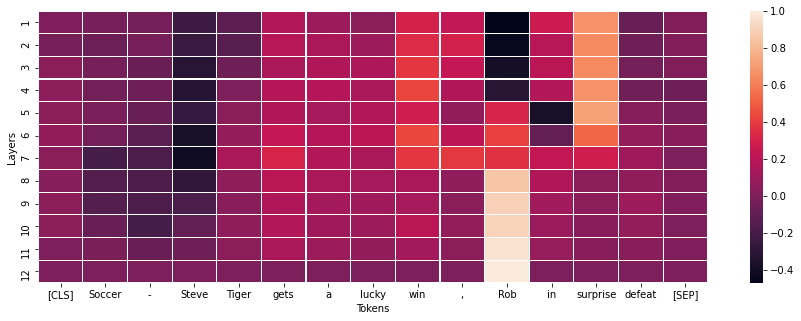

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_word), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

From the image above, we can see that the first few layers of the words close to "Rob" have contributed positivelyto it being tagged as a 'B-PER'. We also find that the last few layers of the target word "Rob" also has a strong positive influence. <br>In the above table and the visualizations  , we saw that the word "surprise" contributed significantly to "Rob" being tagged as 'B-PER'. Lets zoom deeper into  each of the 12 layers for the word "surprise" 

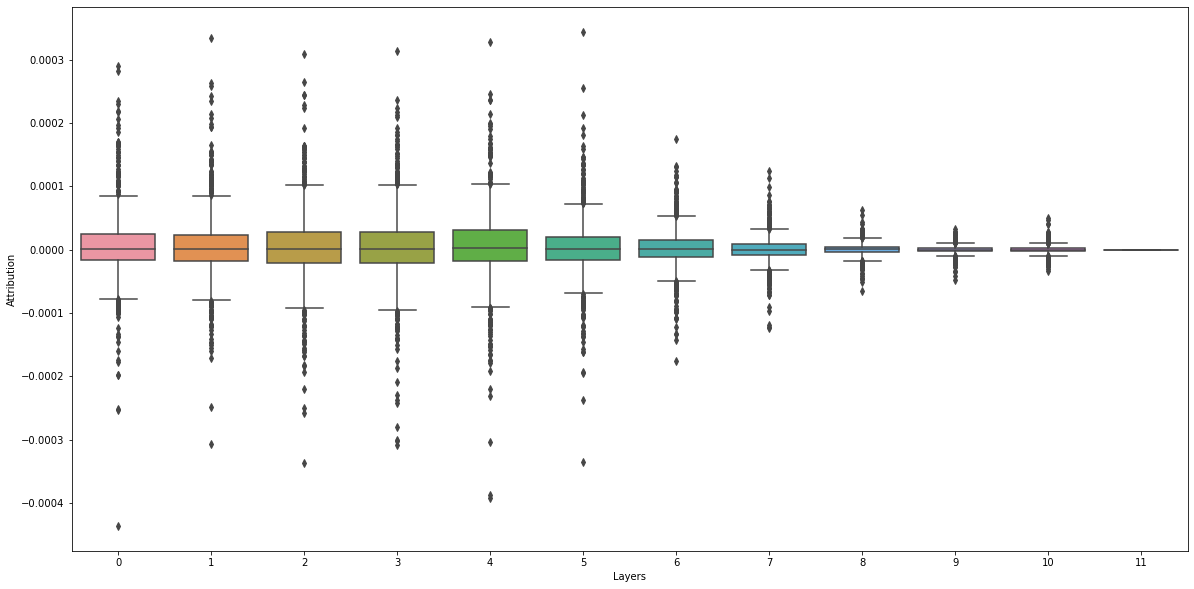

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_token_to_explain_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

We see that the attribution values of each embedding the first 6 layers of the word "surprise" is significant. Also the variance of each embedding in the first 6 layers is high compared to the later layers. The attribution values of embeddings in the later layers are tightly clustered towards zero with little variance

In [46]:
remove_interpretable_embedding_layer(nerModel.model, interpretable_embedding)

## Understanding distribution of attribution

In [47]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [48]:
layer_attrs_token_to_explain_pdf = map(lambda layer_attrs_token_to_explain_dist: pdf_attr(layer_attrs_token_to_explain_dist), layer_attrs_token_to_explain_dist)
layer_attrs_token_to_explain_pdf = np.array(list(layer_attrs_token_to_explain_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_token_to_explain_dist).sum(-1)

# size: #layers
layer_attrs_token_to_explain_pdf_norm = np.linalg.norm(layer_attrs_token_to_explain_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_token_to_explain_pdf = np.transpose(layer_attrs_token_to_explain_pdf)

#size: #bins x #layers
layer_attrs_token_to_explain_pdf = np.divide(layer_attrs_token_to_explain_pdf, layer_attrs_token_to_explain_pdf_norm, where=layer_attrs_token_to_explain_pdf_norm!=0)

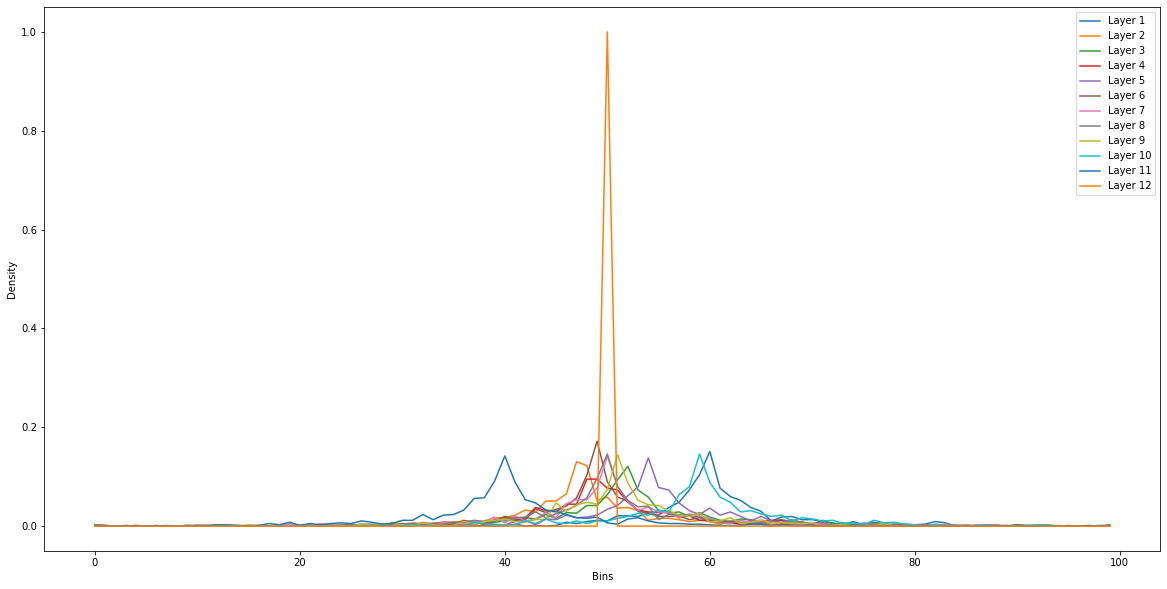

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_token_to_explain_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

The attribution values of  most of the layers follows a uniform distribution. Layer 2 does have a different curve and needs to be analyzed further

## References:

1. https://captum.ai/tutorials/Bert_SQUAD_Interpret
2. https://github.com/MichaMucha/awdlstm-integrated-gradients/blob/master/explaining_predictions_awdlstm.ipynb
3. https://towardsdatascience.com/open-the-black-box-understand-what-drives-predictions-in-deep-nlp-models-833f3dc923d0